In [1]:
%matplotlib inline
import torch
import numpy as np
import os
import torch.distributions as tchd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorboardX import SummaryWriter
import datetime
from torch import nn
import random

tch_dtype = torch.double

The Gaussian Mixture Model is defined as

$$u(\vec{x}) = \sum_{k} \pi_k \mathcal{N}(\vec{x}; \vec{\mu_k}, \vec{\sigma_k})$$

In the 1-d case, the Gaussian function is defined as

$$\mathcal{N}(x;\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}.$$

It is straightforward to show that

$$\frac{\partial^2}{\partial x^2} \mathcal{N}(x;\mu,\sigma) = \frac{-\sigma^2 + (x-\mu)^2 }{\sigma^4} \mathcal{N}(x;\mu,\sigma).$$

This can easily be generalized to 2 dimensions:

$$\mathcal{N}(\vec{x};\vec{\mu},\vec{\sigma}) = \mathcal{N}(x_1;\mu_1,\sigma_1)\cdot \mathcal{N}(x_2;\mu_2,\sigma_2).$$

The Laplacian is therefore

$$(\frac{\partial^2}{\partial x_1^2} + \frac{\partial^2}{\partial x_2^2}) \cdot \mathcal{N}(\vec{x};\vec{\mu},\vec{\sigma}) = (\frac{-\sigma_1^2 + (x_1-\mu_1)^2 }{\sigma_1^4} + \frac{-\sigma_2^2 + (x_2-\mu_2)^2 }{\sigma_2^4}) \cdot \mathcal{N}(\vec{x};\vec{\mu},\vec{\sigma}).$$

# Problem Definition

The `Problem` class defines the true solution; both the `u` potentials and the `f` negative laplacians are implemented in the following.

These will be needed for defining the physics and boundary condition losses.

In [3]:
class Problem:
    """
    Defines the Poisson problem and solutions. This will be used for defining 
    the physics and boundary condition losses.

    Here, we use a Gaussian Mixture Model.
        $$u(x) = \sum_k \pi_k \mathcal{N}(x; \mu_k, \sigma_k)$$
    """
    def __init__(self, mu_np, sigma_np, pi_np, device, dtype):
        """
        Args:
            mu_np (np.ndarray): The numpy array of Guassian means. This 
                should have a shape of `(k, d)`.

            sigma_np (np.ndarray): The numpy array of Guassian scales. This 
                should have a shape of `(k, d)`.

            pi_np (np.ndarray): The numpy array of Guassian weights. This 
                should have a shape of `(k,)`.

            device (torch.device): The pytorch device where the GMM parameters 
                must reside. That being said, the other functions should move 
                things around when the input is not on the same device.

            dtype (torch.dtype): The pythorch floating point data type. Some 
                examples are `torch.double` or `torch.float32`.
        """
        k, d = mu.shape

        self.mu = torch.from_numpy(mu_np).to(device=device, dtype=dtype)
        assert mu.shape == (k, d)
        self.sigma = torch.from_numpy(sigma_np).to(device=device, dtype=dtype)
        assert sigma.shape == (k, d)
        self.pi = torch.from_numpy(pi_np).to(device=device, dtype=dtype)
        assert pi.shape == (k,)

        self.device = device

    def uf(self, x):
        """
        Takes the `x` tensor, and produces a pair of potentials (`u`) and 
        negative laplacians (`f`). This function uses a math formula for 
        computing these quantities.

        Args:
            x (torch.tensor): A pytorch tensor with the shape `(n,d)`, where 
                `n` is the number of samples to be evaluated, and `d` is the 
                dimensionality of the space.

                This tensor could be located on any device.

        Returns:
            tuple(torch.tensor): A `(u, f)` pair where both of them are pytorch 
                tensors with the shape `(n,)`. These tensors must be located on 
                the same device as `x`.
        """
        mu, sigma, pi = self.mu.to(x.device), self.sigma.to(x.device), self.pi.to(x.device)
        n, d = x.shape
        k = mu.shape[-2]
        assert mu.shape == (k, d)
        assert sigma.shape == (k, d)

        # `x_sub_mu` is $$\vec{x} - \vec{mu}$$.
        x_sub_mu = x.reshape(n, 1, d) - mu.reshape(1, k, d)
        assert x_sub_mu.shape == (n, k, d)

        # `exponent` is $$-\frac{(x-\mu)^2}{2\sigma^2}$$.
        exponent = -0.5 * (x_sub_mu / sigma.reshape(1, k, d)).square()
        assert exponent.shape == (n, k, d)

        # `norm_denom` is $$\sqrt{2\pi\sigma_i^2}$$.
        norm_denom = (np.sqrt(2 * np.pi) * sigma.reshape(1, k, d))
        assert norm_denom.shape == (1, k, d)

        # `u_comps` is $$\mathcal{N}(x;\mu_i,\sigma_i)$$.
        u_comps = (exponent.exp() / norm_denom).prod(dim=-1)
        assert u_comps.shape == (n, k)

        # `f_ccomps` is $$\frac{-\sigma_i^2 + x_i^2 }{\sigma_i^4}$$.
        f_ccomps = (x_sub_mu.square() - sigma.reshape(1, k, d).square()) / (sigma.reshape(1, k, d)**4)
        assert f_ccomps.shape == (n, k, d)

        # `f_coeff` is $$\sum_{i=1}^{d} \frac{-\sigma^{()}^2 + x_i^2 }{\sigma_i^4}$$ for 
        f_coeff = f_ccomps.sum(dim=-1)
        assert f_coeff.shape == (n, k)

        # `f_comps` is the laplacian for each gaussian component
        f_comps = f_coeff * u_comps
        assert f_comps.shape == (n, k)

        # `u` is the linear combination of different gaussian components.
        u = (u_comps * pi.reshape(1, k)).sum(dim=-1)
        assert u.shape == (n,)

        # `f` is the linear combination of different gaussian components.
        f = -(f_comps * pi.reshape(1, k)).sum(dim=-1)
        assert f.shape == (n,)

        return u, f

    def u(self, x):
        return self.uf(x)[0]
    
    def f(self, x):
        return self.uf(x)[1]

    def uf_autograd(self, x):
        """
        Takes the `x` tensor, and produces a pair of potentials (`u`) and 
        negative laplacians (`f`). This function uses a math formula for 
        computing these quantities.

        Args:
            x (torch.tensor): A pytorch tensor with the shape `(n,d)`, where 
                `n` is the number of samples to be evaluated, and `d` is the 
                dimensionality of the space.

                This tensor could be located on any device.

        Returns:
            tuple(torch.tensor): A `(u, f)` pair where both of them are pytorch 
                tensors with the shape `(n,)`. These tensors must be located on 
                the same device as `x`.
        """
        n, d = x.shape
        x = nn.Parameter(x)

        # Pytorch distribution objects
        pi_dist = tchd.Categorical(nn.Parameter(self.pi))
        norm_dists = tchd.Independent(tchd.Normal(nn.Parameter(self.mu), nn.Parameter(self.sigma)), 1)
        gmm = tchd.MixtureSameFamily(pi_dist, norm_dists)

        logu = gmm.log_prob(x)
        u = torch.exp(logu)
        u_x, = torch.autograd.grad(u.sum(), [x], grad_outputs=None, retain_graph=True,
                                   create_graph=True, only_inputs=True, allow_unused=False)
        f = 0
        for i in range(d):
            u_xxi, = torch.autograd.grad(u_x[:, i].sum(), [x], grad_outputs=None, retain_graph=True,
                                         create_graph=False, only_inputs=True, allow_unused=True)
            with torch.no_grad():
                f = f - u_xxi[:, i]
        return u, f

## Problem Instantiation

Let's instntiate a simple problem with two Gaussians located at the center of the first and third quarters.

In [4]:
mu_np = np.array([[-0.5, -0.5], [0.5, 0.5]])
sigma_np = np.array([[0.25, 0.25], [0.25, 0.25]])
pi_np = np.array([0.5, 0.5])
problem = Problem(mu_np, sigma_np, pi_np, 'cpu', tch_dtype)

Next, we test whether both of the defined `u` and `f` methods match by evaluating them on random points.

In [5]:
x_rand = torch.rand(128, 2, dtype=tch_dtype) * 2 - 1

u_rand, f_rand = problem.uf(x_rand)
u_rand_ag, f_rand_ag  = problem.uf_autograd(x_rand)
assert torch.allclose(u_rand, u_rand_ag)
assert torch.allclose(f_rand, f_rand_ag)

# Plotting Utility Functions

In [6]:
def eval_grid(model, x1_low, x1_high, x2_low, x2_high, n_grid=50):
    x1_1d = torch.linspace(x1_low, x1_high, n_grid+1, dtype=tch_dtype, device=model.device)[:-1]
    x2_1d = torch.linspace(x2_low, x2_high, n_grid+1, dtype=tch_dtype, device=model.device)[:-1]
    x1_msh, x2_msh = torch.meshgrid(x1_1d, x2_1d, indexing='ij')
    x1 = x1_msh.reshape(-1, 1)
    x2 = x2_msh.reshape(-1, 1)
    x = torch.cat([x1, x2], dim=1)
    u, f = model.uf(x)
    u_grid = u.detach().cpu().numpy().reshape(n_grid, n_grid)
    f_grid = f.detach().cpu().numpy().reshape(n_grid, n_grid)
    return u_grid, f_grid


def do_plot(models, fig, ax_u, ax_f, cax_u, cax_f, n_grid=50):
    model00, model01, model10, model11 = models

    u00, f00 = eval_grid(model00, -1, 0, -1, 0, n_grid=n_grid)
    u01, f01 = eval_grid(model01,  0, 1, -1, 0, n_grid=n_grid)
    u10, f10 = eval_grid(model10, -1, 0,  0, 1, n_grid=n_grid)
    u11, f11 = eval_grid(model11,  0, 1,  0, 1, n_grid=n_grid)

    u0 = np.concatenate([u00, u10], axis=1)
    u1 = np.concatenate([u01, u11], axis=1)
    u = np.concatenate([u0, u1], axis=0)

    f1 = np.concatenate([f00, f10], axis=1)
    f0 = np.concatenate([f01, f11], axis=1)
    f = np.concatenate([f1, f0], axis=0)

    ax_u.set_title('u')
    im_u = ax_u.pcolormesh(u, cmap='hot', shading='auto')
    ax_u.set_xticks([0, n_grid, 2*n_grid])
    ax_u.set_xticklabels([-1, 0, 1])
    ax_u.set_yticks([0, n_grid, 2*n_grid])
    ax_u.set_yticklabels([-1, 0, 1])
    fig.colorbar(im_u, cax=cax_u)

    ax_f.set_title('f')
    im_f = ax_f.pcolormesh(f, cmap='hot', shading='auto')
    ax_f.set_xticks([0, n_grid, 2*n_grid])
    ax_f.set_xticklabels([-1, 0, 1])
    ax_f.set_yticks([0, n_grid, 2*n_grid])
    ax_f.set_yticklabels([-1, 0, 1])
    fig.colorbar(im_f, cax=cax_f)
    
    return u, f

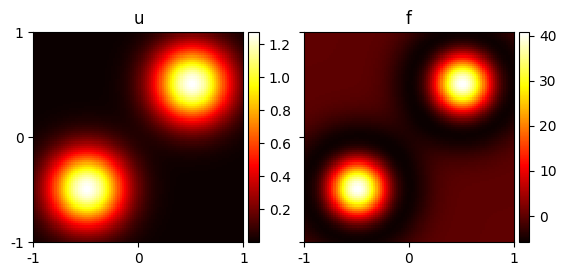

In [7]:
n_rows, n_cols = 1, 2
fig, (ax_u, ax_f) = plt.subplots(n_rows, n_cols, figsize=(3.2*n_cols, 3*n_rows), dpi=100, sharex=True, sharey=True)
cax_u = make_axes_locatable(ax_u).append_axes('right', size='5%', pad=0.05)
cax_f = make_axes_locatable(ax_f).append_axes('right', size='5%', pad=0.05)
ax_u.set_aspect('equal', 'box')
ax_f.set_aspect('equal', 'box')
u, f = do_plot([problem] * 4, fig, ax_u, ax_f, cax_u, cax_f)

In [8]:
class ffnn(nn.Module):
    """basic FF network for approximating functions"""
    def __init__(self, nn_width=10, num_hidden=2, x_dim=2, device=None, dtype=None):
        super().__init__()
        
        self.layer_first = nn.Linear(x_dim, nn_width).to(device=device, dtype=dtype)
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(nn_width, nn_width).to(device=device, dtype=dtype))
        self.layer_hidden = nn.ModuleList(layers)
        
        self.layer_last = nn.Linear(nn_width, 1).to(device=device, dtype=dtype)

        self.device = device
        
    def forward(self, x):
        xt = x
        activation = nn.SiLU()
        u = activation(self.layer_first(xt))
        for hidden in self.layer_hidden:
            u = activation(hidden(u))
        u = self.layer_last(u)[..., 0]
        return u
    
    def uf(self, x):
        """
        Takes the `x` tensor, and produces a pair of approximated potentials (`u`)
        and negative laplacians (`f`).

        Args:
            x (torch.tensor): A pytorch tensor with the shape `(n, d)`, where 
                `n` is the number of samples to be evaluated, and `d` is the 
                dimensionality of the space.

        Returns:
            tuple(torch.tensor): A `(u, f)` pair where both of them are pytorch 
                tensors with the shape `(n,)`.
        """
        x = nn.Parameter(x)
        n_x, d = x.shape

        # Getting the model predictions
        u = self.u(x)
        assert u.shape == (n_x,)

        raise NotImplementedError('define u_lap here')

        return u, -u_lap

    def u(self, x):
        return self.__call__(x)
    
    def f(self, x):
        return self.uf(x)[1]

In [9]:
def sample_unif(n_x, x1_low, x1_high, x2_low, x2_high, device):
    """
    Samples `n_x` uniform points in 2 dimensions within the input bounds.

    Args:
        n_x (int): The number of samples.

        x1_low (float): The lower bound of the first dimension.

        x1_high (float): The upper bound of the first dimension.

        x2_low (float): The lower bound of the second dimension.

        x2_high (float): The upper bound of the second dimension.
        
        device (torch.device): The output pytorch device.

    Returns:
        (torch.tensor): A tensor of shape `(n_x, 2)` located on `device`.
    """

    raise NotImplementedError

    return x

def get_ddloss(model1, model2, x_bndry):
    """
    Defines the domain decomposition loss.

    Args:
        model1 (nn.Module): The first model.

        model2 (nn.Module): The second model.

        x_bndry (torch.tensor): A pytorch tensor of the shape `(n,d)`.

    Returns:
        tuple (torch.tensor): Four scalar loss tensors; `u` and `f` 
            match losses for both models.
    """
    
    raise NotImplementedError

    return loss_udd_m1, loss_udd_m2, loss_fdd_m1, loss_fdd_m2

def get_physloss(model, problem, n_x, x1_low, x1_high, x2_low, x2_high):
    """
    Defines the domain decomposition loss.

    Args:
        model1 (nn.Module): The first model.

        model2 (nn.Module): The second model.

        x_bndry (torch.tensor): A pytorch tensor of the shape `(n,d)`.

    Returns:
        tuple (torch.tensor): Four scalar loss tensors; `u` and `f` 
            match losses for both models.
    """
    
    device = model.device

    x = sample_unif(n_x, x1_low, x1_high, x2_low, x2_high, device)

    # Getting the model predictions of f
    f_model = model.f(x)
    assert f_model.shape == (n_x,)

    # Computing the ground truth f from the problem
    f_prblm = problem.f(x)
    assert f_prblm.shape == (n_x,)

    loss_phys = (f_model - f_prblm).square().mean()
    return loss_phys

In [10]:
# ! rm -rf training_logs/*

In [11]:
timestamp = datetime.datetime.now().isoformat(timespec='seconds')
writer = SummaryWriter(f'training_logs/train-{timestamp}')

# 2. set the model
torch.manual_seed(23939)
np.random.seed(23939)
random.seed(23939)

devices = ['cpu' for _ in range(4)]
models = [ffnn(16, 2, 2, device, tch_dtype) for device in devices]
opts = [torch.optim.Adam(model.parameters(), 0.001) for model in models]
n_epochs = 10000

# The mini-batch size for the interior points
n_x = 8
# The mini-batch size for the boundary points
n_b = 8
# The problem dimension
d = 2

lam_udd = 10.0
lam_fdd = 1.0
lam_bc = 1.0
lam_phys = 0.01

model00, model01, model10, model11 = models
device00, device01, device10, device11 = devices

n_rows, n_cols = 1, 2
fig, (ax_u, ax_f) = plt.subplots(n_rows, n_cols, figsize=(3.2*n_cols, 3*n_rows), dpi=100, sharex=True, sharey=True)
cax_u = make_axes_locatable(ax_u).append_axes('right', size='5%', pad=0.05)
cax_f = make_axes_locatable(ax_f).append_axes('right', size='5%', pad=0.05)
ax_u.set_aspect('equal', 'box')
ax_f.set_aspect('equal', 'box')

for epoch in range(n_epochs):
    [opt.zero_grad() for opt in opts]
    
    raise NotImplementedError 

    loss_00.backward()
    loss_01.backward()
    loss_10.backward()
    loss_11.backward()

    [opt.step() for opt in opts]

    loss = (loss_00.item() + loss_01.item() + loss_10.item() + loss_11.item()) / 4

    if epoch % 100 == 0:
        print(f'epoch {epoch}, loss = {loss:.4f}')
        
    if epoch % 100 == 0:
        do_plot(models, fig, ax_u, ax_f, cax_u, cax_f)
        fig.set_tight_layout(True)
        writer.add_figure('output_visualization', fig, epoch)
        writer.flush()

writer.flush()

epoch 0, loss = 1.3066
epoch 100, loss = 1.0667
epoch 200, loss = 1.0404
epoch 300, loss = 1.4273
epoch 400, loss = 0.6418
epoch 500, loss = 0.5999
epoch 600, loss = 0.4997
epoch 700, loss = 1.8960
epoch 800, loss = 1.1262
epoch 900, loss = 0.4665
epoch 1000, loss = 1.0161
epoch 1100, loss = 0.8094
epoch 1200, loss = 0.4683
epoch 1300, loss = 0.4867
epoch 1400, loss = 0.4138
epoch 1500, loss = 0.3343
epoch 1600, loss = 0.2399
epoch 1700, loss = 0.2432
epoch 1800, loss = 0.2366
epoch 1900, loss = 0.2103
epoch 2000, loss = 0.2158
epoch 2100, loss = 0.1856
epoch 2200, loss = 0.2792
epoch 2300, loss = 0.1901
epoch 2400, loss = 0.1584
epoch 2500, loss = 0.2363
epoch 2600, loss = 0.1571
epoch 2700, loss = 0.1553
epoch 2800, loss = 0.1532
epoch 2900, loss = 0.1040
epoch 3000, loss = 0.1034
epoch 3100, loss = 0.0801
epoch 3200, loss = 0.0744
epoch 3300, loss = 0.0596
epoch 3400, loss = 0.1252
epoch 3500, loss = 0.0725
epoch 3600, loss = 0.0966
epoch 3700, loss = 0.0803
epoch 3800, loss = 0.050

# The Fitted Neural Approximation 

The following is the trained network predictions with `lam_fdd = 1.0` (i.e., when the second derivative continuity was enforced).

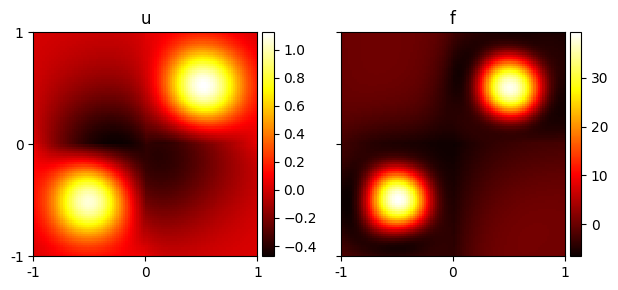

In [12]:
do_plot(models, fig, ax_u, ax_f, cax_u, cax_f)
fig.set_tight_layout(True)
fig

The following is the trained network predictions with `lam_fdd = 0.0` (i.e., without any second derivative continuity enforcement).

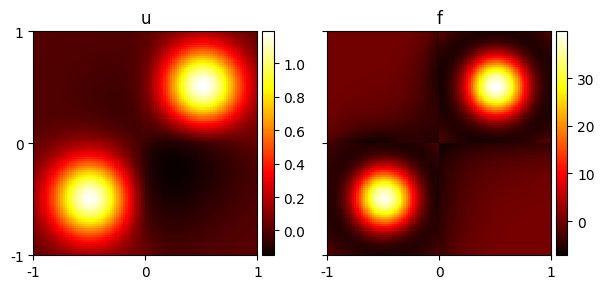

In [14]:
do_plot(models, fig, ax_u, ax_f, cax_u, cax_f)
fig.set_tight_layout(True)
fig